In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [3]:
import numpy as np 
import pandas as pd
import librosa
from tensorflow import keras

In [4]:
import matplotlib.pyplot as plt
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
crema = "/kaggle/input/cremad/AudioWAV/"


In [5]:
import os
ravdess_dir_list=os.listdir(ravdess)
file_emotion=[]
file_path=[]

for dir in ravdess_dir_list:
    actor = os.listdir(ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [6]:
crema_dir_list=os.listdir(crema)
file_emotion=[]
file_path=[]

for file in crema_dir_list:
    # storing file paths
    file_path.append(crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


(77988,) 1 22050


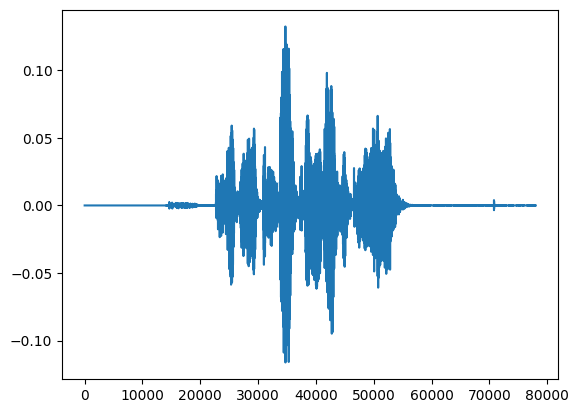

In [7]:
ex_path=ravdess_df['Path'][0]
aud,sr=librosa.load(ex_path)
print(aud.shape,aud.ndim,sr)
plt.plot(aud)

#plt.figure()
#librosa.display.waveplot(aud, sr=sr)
plt.show()

In [8]:
data_path = pd.concat([ravdess_df, crema_df], axis = 0)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [9]:
data_path['Emotions']=data_path['Emotions'].map({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, 'disgust':7, 'surprise':8,'Unknown':9})

In [23]:
from sklearn.model_selection import train_test_split
X=data_path[['Path']]
y=data_path[['Emotions']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_df=pd.concat([X_train,y_train],axis=1)
train_df.head()
test_df=pd.concat([X_test,y_test],axis=1)

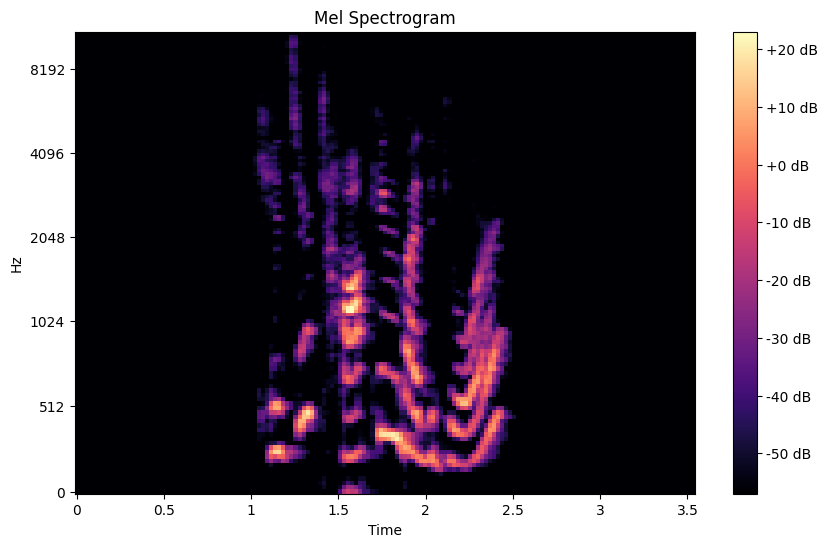

In [12]:
def create_mel(path):
    aud,sr=librosa.load(path)

    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=aud, sr=sr)
    
    # Convert to decibels
    mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)
    return mel_spectrogram
    # Plot the Mel spectrogram
mel_spectrogram=create_mel(ravdess_df['Path'][0])   
    
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.show()

In [13]:
# created df with path and mapped emotions
# function for creating mel spectrogram that takes path as input
# split X and y
# now, make batches , call create_mel , call feature extraction to create
# set fixed input , data augmentation on spec , input this to cnn model

In [14]:
def pad_spectrogram(spectrogram, target_length):
    current_length = spectrogram.shape[1]
    if current_length >= target_length:
        return spectrogram[:, :target_length] #truncation
    else:
        pad_width = target_length - current_length
        return np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')

In [15]:
def preprocess_audio(path, target_duration=4, sr=22050):
    mel_spec_db=create_mel(path)
    target_length=172 #duration*sr/hop_length , it is no. of time frames
    # Pad or truncate to fixed size
    mel_spec_fixed = pad_spectrogram(mel_spec_db, target_length)
    return mel_spec_fixed

In [16]:
def batch_generator(data_path, batch_size, sr=22050):
    """
    Yields batches of Mel spectrograms and labels from a DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'Path' column for audio file paths and 'Label' column for labels.
        batch_size (int): Number of samples per batch.
        n_mels (int): Number of Mel bands to generate.
        n_fft (int): Length of the FFT window.
        hop_length (int): Number of samples between successive frames.
        sr (int): Sampling rate.
    
    Yields:
        X_batch (np.ndarray): Batch of Mel spectrograms (shape: [batch_size, n_mels, time, 1]).
        y_batch (np.ndarray): Batch of labels (one-hot encoded).
    """
    num_samples = len(data_path)
    while True:  # Infinite loop for generator
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_df = data_path.iloc[start_idx:end_idx]
            
            X_batch = []
            y_batch = []
            
            for _, row in batch_df.iterrows():
                mel_spec_db=preprocess_audio(row['Path'])
                # Add a channel dimension (for CNN input)
                mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
                
                X_batch.append(mel_spec_db)
                y_batch.append(row['Emotions'])  # Assuming labels are already encoded
            
            # Convert to NumPy arrays
            X_batch = np.array(X_batch, dtype=np.float32)
            y_batch = np.array(y_batch, dtype=np.int32)
            
            yield X_batch, keras.utils.to_categorical(y_batch,num_classes=9)  # One-hot encode labels


In [24]:
batch_size=70
sr=22050
train_gen = batch_generator(train_df, batch_size=batch_size,sr=sr)
test_gen = batch_generator(test_df, batch_size=batch_size,sr=sr)


In [25]:
X_batch, y_batch = next(train_gen)
print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")
X_batch, y_batch = next(test_gen)
print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")


X_batch shape: (70, 128, 172, 1), y_batch shape: (70, 9)
X_batch shape: (70, 128, 172, 1), y_batch shape: (70, 9)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 172, 1)),  
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))  # Use ceiling to ensure rounding up

# Train the model
model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.2403 - loss: 13.9987
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.4122 - loss: 1.4810
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.5198 - loss: 1.2456
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.6102 - loss: 1.0617
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.6692 - loss: 0.8981
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.7062 - loss: 0.7961
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.7340 - loss: 0.7253
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.7672 - loss: 0.6377
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8172 - loss: 0.5197
Epoch 10/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8439 - loss: 0.4499


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 170, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 83, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 41, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 39360)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       2,519,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,587,773 (28.95 MB)

 Trainable params: 2,529,257 (9.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,058,516 (19.30 MB)

In [ ]:
train_loss,train_accuracy=model.evaluate(train_gen)
test_loss,test_accuracy=model.evaluate(test_gen)
print(f"train_loss: {train_loss} ,train_accuracy: {train_accuracy} ")
print(f"test_loss: {test_loss} ,test_accuracy: {test_accuracy} ")